In [156]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli

from Code import ULA
from Code import Algo1
from Code import ZVnbrosse

In [157]:
def r(theta, x):
    return np.exp(theta.T @ x)/(1+np.exp(theta.T @ x))

def f_grad(theta):
    n = X_reg.shape[0]
    p = X_reg.shape[1]
    lambda_c = 3*p / np.pi**2
    LOG = np.zeros((p))
    for i in range(n):
        LOG = LOG + X_reg[i].reshape((p)) / (1+np.exp(theta.T @ X_reg[i].reshape((p))))
    F = X_reg.T @ Y_reg - LOG + 1/100* theta
    return F

def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [158]:
data = np.loadtxt("data/swiss.txt")
Y_reg = data[:,-1]
X_reg = data[:,0:-1]
# Normalization of the covariates
X_reg = np.dot(X_reg - np.mean(X_reg, axis=0), np.diag(1./np.std(X_reg, axis=0)))

In [159]:
dim = X_reg.shape[1]
h = 0.12
n = 2000
N_train = 10
N_test = 100
deg = 1

np.random.seed(55)

In [160]:
f_target = 'sum'

In [ ]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=100000,f_grad=f_grad)

In [ ]:
print ('expectation = ',local_weighted_estimator(X))
ULA.plot_distr(X,Z,G,0)
ULA.plot_distr(X,Z,G,1)
ULA.plot_distr(X,Z,G,2)
ULA.plot_distr(X,Z,G,3)

In [ ]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad)
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

In [ ]:
ULA.plot_distr(XX_test[5],ZZ_test[5],GG_test[5],0)
ULA.plot_distr(XX_test[5],ZZ_test[5],GG_test[5],1)
ULA.plot_distr(XX_test[5],ZZ_test[5],GG_test[5],2)
ULA.plot_distr(XX_test[5],ZZ_test[5],GG_test[5],3)

In [ ]:
Betas, degrees = Algo1.G_pml_fit_mean(XX,f_target='sum',max_deg = deg)

In [ ]:
k_comb = np.zeros((dim,dim), dtype=np.int16)
for i in range(dim):
    k_comb[i,i] = 1

In [ ]:
i_test = 5
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[i_test],GG_test[i_test], ZZ_test[i_test], h, degrees,Betas, 100)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

In [ ]:
P_test = estimator(XX_test)

In [ ]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVnbrosse.ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_2 = np.array(res_cv_2).reshape(-1)

In [ ]:
def save_plot(M_test, n_tilde):
    all_data = [P_test]
    all_data.append(P_test - M_test.sum(axis = 0))
    all_data.append(res_zv_1)
    all_data.append(res_cv_1)
        
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,5), ('O', 'CV_B', 'ZV', 'CV'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/BLR_banknotes_{}d_violin_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

    all_data.append(res_zv_2)
    all_data.append(res_cv_2)
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,7), ('O', 'CV_B', 'ZV-1', 'CV-1', 'ZV-2', 'CV-2'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/BLR_banknotes_{}d_violin_full_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

In [ ]:
for n_tilde in [50, 100]:
    M_test = np.empty((len(k_comb),P_test.shape[0]))
    for i in range(len(k_comb)):
        M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, h, degrees,Betas, n_tilde, n_jobs=8)
    save_plot(M_test, n_tilde)
    np.save("Algo1_logs/BLR_banknotes_{}d_M_test(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).npy".
            format(dim, h, n, n_tilde,f_target), M_test)
    print("plots_saved for n_tilde = {}".format(n_tilde))

In [108]:
M_test = np.load('Algo1_logs/BLR_banknotes_4d_M_test(h = 0.1, n = 1000, K = 1, n_tilde=50, f_target = sum).npy')

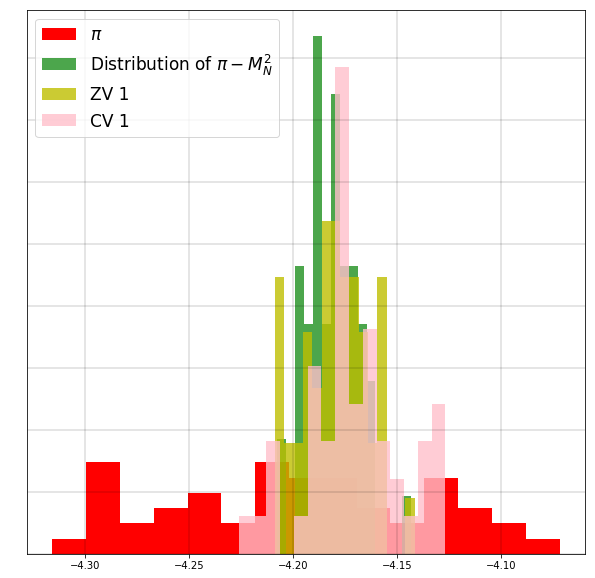

In [109]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.7, label="Distribution of $\pi - M^2_N$")

plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.8, label="ZV 1")
# plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.8, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.8, label="CV 1")
# plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.8, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
# plt.xlim(-1.339, -1.338)
plt.show()

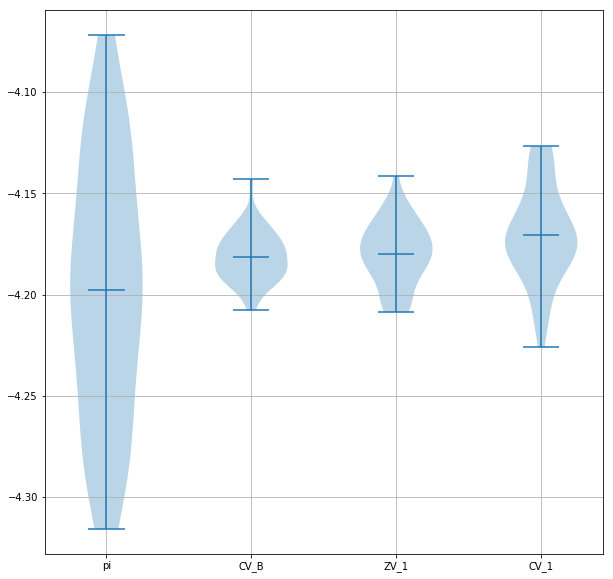

In [136]:
all_data = [P_test]
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
# all_data.append(res_zv_2)
all_data.append(res_cv_1)
# all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.xticks(np.arange(1,5), ('pi', 'CV_B', 'ZV_1','CV_1'))
plt.grid()
plt.show()

In [111]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i+1].sum(axis = 0)).var(ddof = 1))
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

          Variance of Pi =  0.00397315392357152
Variance of new estimator = 0.003948700327118479
Variance of new estimator = 0.003059943117931124
Variance of new estimator = 0.0029462804156944636
Variance of new estimator = 0.00014965401645997034
        Variance of CV 1 =  0.0005388099244714072
        Variance of CV 2 =  3.0503698403532516e-06
        Variance of ZV 1 =  0.0002522190307687482
        Variance of ZV 2 =  2.609471327395953e-06


In [112]:
print ('VRF CVB = ',P_test.var(ddof = 1)/ (P_test - M_test.sum(axis = 0)).var(ddof=1))
print ('VRF CV1 = ',P_test.var(ddof = 1)/res_cv_1.var(ddof = 1))
print ('VRF CV2 = ',P_test.var(ddof = 1)/res_cv_2.var(ddof = 1))
print ('VRF ZV1 = ',P_test.var(ddof = 1)/res_zv_1.var(ddof = 1))
print ('VRF ZV2 = ',P_test.var(ddof = 1)/res_zv_2.var(ddof = 1))

VRF CVB =  26.548929441090305
VRF CV1 =  7.373943468968826
VRF CV2 =  1302.5154756681584
VRF ZV1 =  15.752791973950535
VRF ZV2 =  1522.5896072735984
